In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
df = pd.read_excel('/Users/AribM/Desktop/Mutual Funds India-Data Analysis/processed_data.xlsx')
df = df[df['Scheme_Category'].str.contains('Debt')]

In [2]:
df = df[(df['CAGR'] >= 5) & 
        (df['std_dev'].between(0,2)) &
        (df['Sortino_Ratio'] > 0) &
        (df['Sharpe_annual'] > 0)]
df = df[df['active_years'] >= 3]

In [3]:
df = df.sort_values(by='CAGR',ascending=False)
df = df.drop_duplicates(subset=['Fund_House','Scheme_Type','Scheme_Category','active_years'])
df.head(5)

,Fund_House,Scheme_Type,Scheme_Category,Scheme_Code,Scheme_Name,std_dev,active_years,CAGR,Sortino_Ratio,Sharpe_annual
3932,Nippon India Mutual Fund,Open Ended Schemes,Debt Scheme - Long Duration Fund,143707,NIPPON INDIA NIVESH LAKSHYA FUND - DIRECT Plan...,0.324,5,9.145,1.018812,1.788647
1787,DSP Mutual Fund,Open Ended Schemes,Debt Scheme - Gilt Fund,119099,DSP Government Securities Fund - Direct Plan -...,0.208,5,8.900,1.484885,2.684988
1955,Aditya Birla Sun Life Mutual Fund,Open Ended Schemes,Debt Scheme - Medium Duration Fund,119539,Aditya Birla Sun Life Medium Term Plan - Growt...,0.568,5,8.824,0.905629,1.014105
1466,Bandhan Mutual Fund,Open Ended Schemes,Debt Scheme - Gilt Fund,118464,BANDHAN Government Securities Fund- Investmen...,0.231,5,8.821,1.328731,2.409924
2034,SBI Mutual Fund,Open Ended Schemes,Debt Scheme - Gilt Fund,119707,SBI MAGNUM GILT FUND - DIRECT PLAN - GROWTH,0.202,5,8.795,1.507305,2.744109


These debt schemes have less volatility and less return than equity and hybrid funds as expected in debt schemes.
Debt Funds are much safer compared to other schemes and generally provide stable returns.

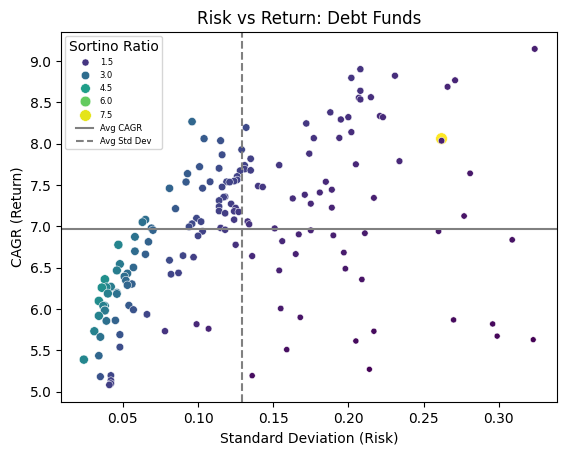

In [4]:
# Risk Vs Return in Debt Schemes
# The Data has a few outliers with standard deviations of much higher than normal which makes the data look skewed
# Due to this reason I will use the values inside the Inter Quartile Range for a better visualization
Q1 = df[['CAGR', 'std_dev']].quantile(0.25)
Q3 = df[['CAGR', 'std_dev']].quantile(0.75)
IQR = Q3 - Q1

# Define acceptable range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering out outliers
df_plot = df[
    (df['CAGR'] >= lower_bound['CAGR']) & (df['CAGR'] <= upper_bound['CAGR']) &
    (df['std_dev'] >= lower_bound['std_dev']) & (df['std_dev'] <= upper_bound['std_dev'])
]
df_plot = df_plot.dropna()
sns.scatterplot(data=df_plot,y='CAGR',x='std_dev',size='Sortino_Ratio',hue='Sortino_Ratio',palette = 'viridis')
plt.axhline(df_plot['CAGR'].mean(), linestyle='solid', color='gray', label="Avg CAGR")
plt.axvline(df_plot['std_dev'].mean(), linestyle='dashed', color='gray', label="Avg Std Dev")
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("CAGR (Return)")
plt.title("Risk vs Return: Debt Funds")
plt.legend(title="Sortino Ratio", loc="upper left", fontsize=6)
plt.show()

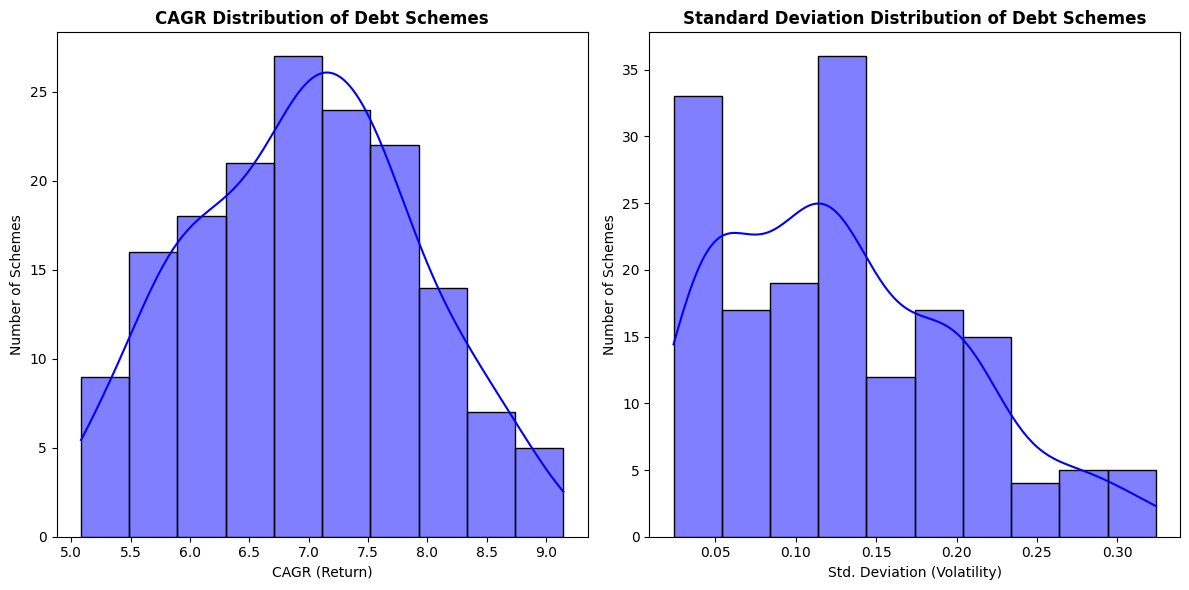

In [5]:
# Returns and Volatility Distribution of Debt Funds:
fig,ax = plt.subplots(1,2,figsize=(12,6))
# Plotting both distributions on a single plot 
sns.histplot(data=df_plot['CAGR'],bins=10,kde=True,color='blue',ax=ax[0]) # Subplot 1
sns.histplot(data=df_plot['std_dev'],bins=10,kde=True,color='blue',ax=ax[1]) # Subplot 2
# Formatting SubPlot 1
ax[0].set_title("CAGR Distribution of Debt Schemes",fontsize=12,fontweight='bold')
ax[0].set_xlabel('CAGR (Return)',fontsize=10)
ax[0].set_ylabel('Number of Schemes',fontsize=10)
# Formatting Subplot 2
ax[1].set_title("Standard Deviation Distribution of Debt Schemes",fontsize=12,fontweight='bold')
ax[1].set_xlabel('Std. Deviation (Volatility)',fontsize=10)
ax[1].set_ylabel('Number of Schemes',fontsize=10)

fig.tight_layout()

### Best Debt Funds According to different Scenarios
#### Most of the people invest in Debt Schemes for high stability and therefore the schemes having the least volatility are best for this purpose.
#### Apart from that if an Investor invests only in debt funds (Hates Equity for some reason XD), in that case they might want to have a higher return from some schemes.
#### Considering both scenarios and plotting the best funds for each purpose

In [6]:
# Checking the mean standard deviation and mean CAGR of debt funds
print(df_plot['std_dev'].mean())
print(df_plot['CAGR'].mean())

0.12956441717791412
6.962552147239264


In [7]:
# Getting the best funds according to risk and returns
df_top_cagr = df_plot[(df_plot['Sortino_Ratio'] > 0 )&   # Funds with best CAGR but good risk adjustment
                     (df_plot['Sharpe_annual'] > 0) ]
df_top_cagr = df_top_cagr.sort_values(by='CAGR',ascending=False)

df_low_volatility = df_plot[(df_plot['std_dev'] <= 0.13) & # less than mean std_dev 
                      (df_plot['CAGR'] >= 6.96) &          # greater than mean CAGR
                      (df_plot['Sortino_Ratio'] > 0) &
                      (df_plot['Sharpe_annual'] > 0)]
df_low_volatility = df_low_volatility.sort_values(by='std_dev',ascending=True)

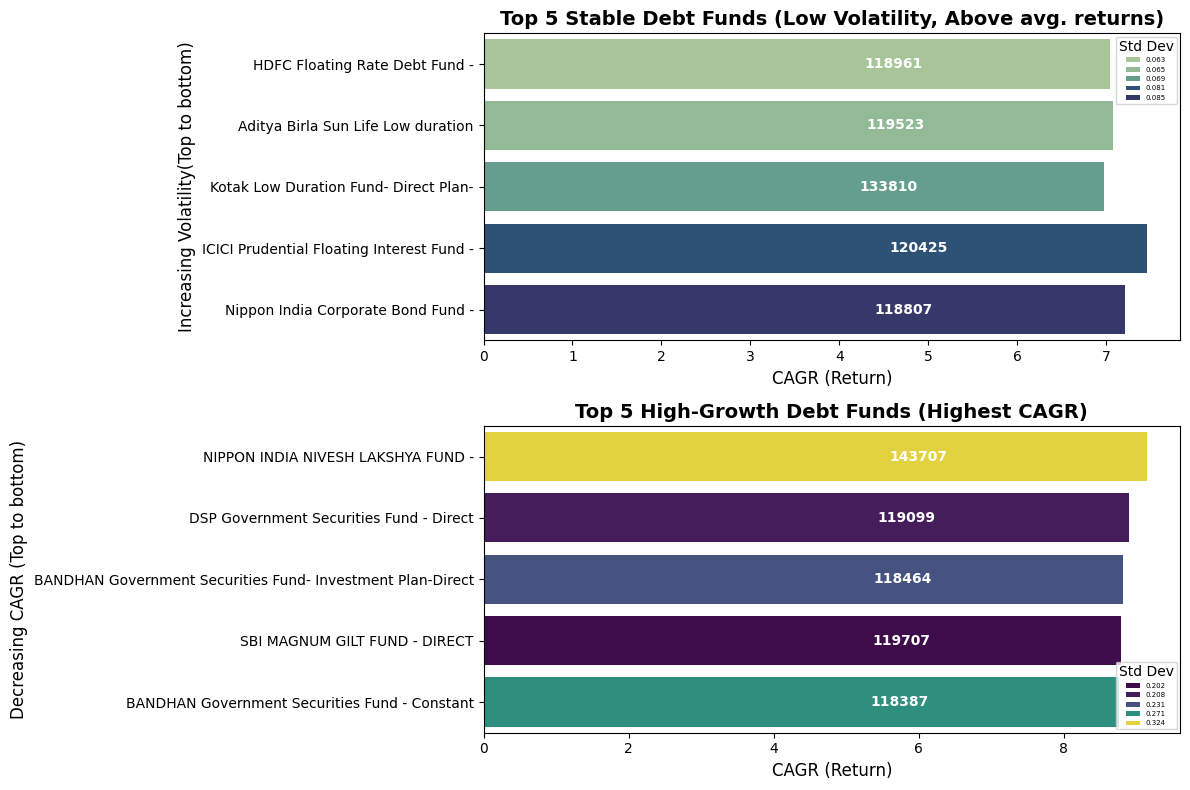

In [8]:
df_low_volatility["short_name"] = df_low_volatility["Scheme_Name"].apply(lambda x: " ".join(x.split()[:6])).copy() #Short Names for fitting in Chart
fig,ax_2 = plt.subplots(2,1,figsize=(12,8))
plt.subplots_adjust(wspace=0.4)
# Plot 1:
sns.barplot(data=df_low_volatility.nsmallest(5,"std_dev"),x='CAGR',y='short_name',hue='std_dev',palette='crest',ax=ax_2[0])
for row in df_low_volatility.nsmallest(5, "std_dev").itertuples():
    ax_2[0].text(
        row.CAGR * 0.7 ,  # Adjust position to be inside
        row.short_name, 
        str(row.Scheme_Code), 
        ha="right", 
        va="center", 
        fontsize=10, 
        color="white", 
        fontweight="bold",

    )
ax_2[0].set_title("Top 5 Stable Debt Funds (Low Volatility, Above avg. returns)", fontsize=14, fontweight="bold")
ax_2[0].set_xlabel("CAGR (Return)", fontsize=12)
ax_2[0].set_ylabel("Increasing Volatility(Top to bottom)", fontsize=12)
    
# Plot 2:
df_top_cagr["short_name"] = df_top_cagr["Scheme_Name"].apply(lambda x: " ".join(x.split()[:6])).copy() #Short Names for fitting in Chart
sns.barplot(data=df_top_cagr.nlargest(5,"CAGR"),x='CAGR',y='short_name',hue='std_dev',palette='viridis',ax=ax_2[1])
for index, row in enumerate(df_top_cagr.nlargest(5, "CAGR").itertuples()):
    ax_2[1].text(
        row.CAGR * 0.7,  # Adjust position to be inside
        index, 
        str(row.Scheme_Code), 
        ha="right", 
        va="center", 
        fontsize=10, 
        color="white", 
        fontweight="bold",
    )

ax_2[1].set_title("Top 5 High-Growth Debt Funds (Highest CAGR)", fontsize=14, fontweight="bold")
ax_2[1].set_xlabel("CAGR (Return)", fontsize=12)
ax_2[1].set_ylabel("Decreasing CAGR (Top to bottom)", fontsize=12)
ax_2[0].legend(title="Std Dev", loc="upper right", fontsize=5)
ax_2[1].legend(title="Std Dev", loc="lower right", fontsize=5)
fig.tight_layout()
plt.show()